In [1]:
import numpy as np
import numpy.linalg as la
import os
import sys
import cv2
import torch
import copy
import imageio
import random
import scipy
import pprint
import json
from tqdm import tqdm
from fastseg import MobileV3Small
from IPython.display import Video
from IPython.display import HTML
from base64 import b64encode
%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt
from pathlib import Path
np.set_printoptions(suppress=True)

In [2]:
class IPM(object):
    """
    Inverse perspective mapping to a bird-eye view. Assume pin-hole camera model.
    There are detailed explanation of every step in the comments, and variable names in the code follow these conventions:
    `_c` for camera coordinates
    `_w` for world coordinates
    `uv` for perspective transformed uv 2d coordinates (the input image)
    """
    def __init__(self, camera_info, ipm_info):
        self.camera_info = camera_info
        self.ipm_info = ipm_info

        ## Construct matrices T, R, K
        self.T = np.eye(4)
        self.T[2, 3] = -camera_info.camera_height # 4x4 translation matrix in 3d space (3d homo coordinate)
        _cy = np.cos(camera_info.yaw   * np.pi / 180.)
        _sy = np.sin(camera_info.yaw   * np.pi / 180.)
        _cp = np.cos(camera_info.pitch * np.pi / 180.)
        _sp = np.sin(camera_info.pitch * np.pi / 180.)
        tyaw = np.array([[_cy, 0, -_sy],
                         [0, 1, 0],
                         [_sy, 0, _cy]])
        tyaw_inv = np.array([[_cy, 0, _sy],
                             [0, 1, 0],
                             [-_sy, 0, _cy]])
        tpitch = np.array([[1, 0, 0],
                           [0, _cp, -_sp],
                           [0, _sp, _cp]])
        tpitch_inv = np.array([[1, 0, 0],
                               [0, _cp, _sp],
                               [0, -_sp, _cp]])
        self.R = np.dot(tyaw, tpitch) # 3x3 Rotation matrix in 3d space
        self.R_inv = np.dot(tpitch_inv, tyaw_inv)
        self.K = np.array([[camera_info.f_x, 0, camera_info.u_x],
                           [0, camera_info.f_y, camera_info.u_y],
                           [0, 0, 1]]).astype(float) # 3x3 intrinsic perspective projection matrix

        ## The ground plane z=0 in the world coordinates, transform to a plane `np.dot(self.normal_c, point) = self.const_c` in the camera coordinates. 
        # This is used to find (x,y,z)_c according to (u,v). See method `uv2xy` for detail.
        self.normal_c = np.dot(self.R, np.array([0,0,1])[:, None]) # normal of ground plane equation in camera coordinates
        self.const_c = np.dot(self.normal_c.T, 
                              np.dot(self.R,
                                     np.dot(self.T, np.array([0,0,0,1])[:, None])[:3])) # constant of ground plane equation in camera coordinates

        ## Get the limit to be converted on the uv map (must below vanishing point)
        # To calculate (u,v) of the vanishing point on the uv map of delta vector v=[0,1,0] in the world coordinates
        # homo coordinates of a vector will be v_4 = [0, 1, 0, 0], mapping this vector to camera coordinate:
        # vc_3 = np.dot(R_4, np.dot(T_4, v_4))[:3] = np.dot(R, v), the 2d homo coordinate of the vanishing point will be at 
        # lim_{\lambda -> \infty} np.dot(K, lambda * vc_3) = np.dot(K, vc_3)

        # lane_vec_c = np.dot(self.R, np.array([0,1,0])[:, None]) # lane vector in camera coordinates
        # lane_vec_homo_uv = np.dot(self.K, lane_vec) # lane vector on uv map (2d homo coordinate)
        lane_vec_homo_uv = np.dot(self.K, np.dot(self.R, np.array([0,1,0])[:, None])) # lane vector on uv map (2d homo coordinate)
        vp = self.vp = lane_vec_homo_uv[:2] / lane_vec_homo_uv[2] # coordinates of the vanishing point of lanes on uv map
        # print(vp)
        # UGLY: This is an ugly op to ensure the converted area do not goes beyond the vanishing point, as the camera intrinsic/extrinsic parameters are not accurate in 
        # my case.

        ipm_top = self.ipm_top = max(ipm_info.top, vp[1][0]+ipm_info.input_height/15) 
        # print(ipm_top)
        uv_limits = self.uv_limits = np.array([[ipm_info.left, ipm_top],
                              [ipm_info.right, ipm_top],
                              [vp[0][0], ipm_info.bottom],
                              [vp[0][0], ipm_info.bottom]]).T # the limits of the area on the uv map to be IPM-converted

        ## The x,y limit in the world coordinates is used to calculate xy_grid, and then the corresponding uv_grid
        self.xy_limits = self.uv2xy(uv_limits)
        xmin, xmax = min(self.xy_limits[0]), max(self.xy_limits[0])
        ymin, ymax = min(self.xy_limits[1]), max(self.xy_limits[1])
        stepx = (xmax - xmin) / ipm_info.out_width  # x to output pixel ratio
        stepy = (ymax - ymin) / ipm_info.out_height # y to output pixel ratio

        # xy_grid: what x,y coordinates in world coordinates will be stored in every output image pixel
        self.xy_grid = np.array([[(xmin + stepx * (0.5 + j), ymax - stepy * (0.5 + i)) for j in range(ipm_info.out_width)]
                                 for i in range(ipm_info.out_height)]).reshape(-1, 2).T
        # uv_grid: what u,v coordiantes on the uv map will be stored in every output image pixel
        self.uv_grid = self.xy2uv(self.xy_grid).astype(int)
        self.uv_grid = self.uv_grid * ((self.uv_grid[0] > ipm_info.left) * (self.uv_grid[0] < ipm_info.right) *\
                                       (self.uv_grid[1] > ipm_top) * (self.uv_grid[1] < ipm_info.bottom))
        self.uv_grid = tuple(self.uv_grid.reshape(2, ipm_info.out_height, ipm_info.out_width))
        self.uv_grid = (self.uv_grid[1], self.uv_grid[0])

    def xy2uv(self, xys): # all points have z=0 (ground plane): w (u,v,1) = KRT (x,y,z)_w
        xyzs = np.vstack((xys, -self.camera_info.camera_height * np.ones(xys.shape[1]))) # (x,y,z) after translation
        xyzs_c = np.dot(self.K, np.dot(self.R, xyzs)) # w(u,v,1) (2d homo)
        return xyzs_c[:2] / xyzs_c[2]

    def uv2xy(self, uvs): # all points have z=0 (ground plane): find (x,y,z)_c first, then x_w, y_w = (R^-1 (x,y,z)_c)[:2]
        uvs = (uvs - np.array([self.camera_info.u_x, self.camera_info.u_y])[:, None]) /\
              np.array([self.camera_info.f_x, self.camera_info.f_y])[:, None] # converted using camara intrinsic parameters
        uvs = np.vstack((uvs, np.ones(uvs.shape[1])))
        xyz_c = (self.const_c / np.dot(self.normal_c.T, uvs)) * uvs # solve the equation, get (x,y,z) on the ground plane in camera coordinates
        xy_w = np.dot(self.R_inv, xyz_c)[:2, :] # (x, y) on the ground plane in the world coordinates
        return xy_w

    def __call__(self, img):
        return self.ipm(img)

    def ipm(self, img):
        out_img = img[self.uv_grid].copy()
        # out_img = np.rot90(out_img, 2) #rotate the image 180 degrees
        return out_img

    def reverse_ipm(self, img, shape=None):
        if shape is None:
            shape = img.shape
        out_img = np.zeros(shape)
        out_img[self.uv_grid] = img
        return out_img

class _DictObjHolder(object):
    def __init__(self, dct):
        self.dct = dct

    def __getattr__(self, name):
        return self.dct[name]


In [3]:
class CameraAudi(object):
  def __init__(self, image_width=1920, image_height=1208, field_of_view_deg=60):
    # Constant of the camera
    self.image_width = image_width
    self.image_height = image_height
    self.field_of_view_deg = field_of_view_deg
    self.intrinsic_matrix = 0
    self.inverse_intrinsic_matrix = 0
    self.estimated_pitch_deg = 0
    self.estimated_yaw_deg = 0
    self.estimated_height = 0
    self.estimated_roll_deg = 0

  def get_intrinsic_matrix(self, jsonfile):
    with open (jsonfile, 'r') as f:
      config = json.load(f)
    intr_mat_undist = \
                np.asarray(config['cameras']['front_center']['CamMatrix'])
    self.intrinsic_matrix = intr_mat_undist
    self.inverse_intrinsic_matrix = la.inv(self.intrinsic_matrix)
      

  def undistort_image(self, image, cam_name, jsonfile):
    with open (jsonfile, 'r') as f:
          config = json.load(f)
    if cam_name in ['front_left', 'front_center', \
                    'front_right', 'side_left', \
                    'side_right', 'rear_center']:
      # get parameters from config file
      intr_mat_undist = \
                np.asarray(config['cameras'][cam_name]['CamMatrix'])
      intr_mat_dist = \
                np.asarray(config['cameras'][cam_name]['CamMatrixOriginal'])
      dist_parms = \
                np.asarray(config['cameras'][cam_name]['Distortion'])
      lens = config['cameras'][cam_name]['Lens']
      
      if (lens == 'Fisheye'):
          return cv2.fisheye.undistortImage(image, intr_mat_dist,\
                                    D=dist_parms, Knew=intr_mat_undist)
      elif (lens == 'Telecam'):
          return cv2.undistort(image, intr_mat_dist, \
                    distCoeffs=dist_parms, newCameraMatrix=intr_mat_undist)
      else:
          return image
    else:
        return image

  def get_extrinsic(self, jsonfile):
    with open (jsonfile, 'r') as f:
      config = json.load(f)
    view = config['cameras']['front_center']['view']

    trans = self.get_transform_from_global(view=view)

    yaw = np.arctan2(trans[1][0], trans[0][0])
    pitch = np.arctan2(-trans[2][0], np.sqrt(trans[2][1]**2 + trans[2][2]**2))
    roll = np.arctan2(trans[2][1],trans[2][2])

    self.estimated_yaw_deg = np.rad2deg(yaw)
    self.estimated_pitch_deg = np.rad2deg(pitch)
    self.estimated_roll_deg = np.rad2deg(roll)

    origin = self.get_origin_of_a_view(view=view)
    self.estimated_height = origin[2] + 0.75

  def get_axes_of_a_view(self, view):
    x_axis = view['x-axis']
    y_axis = view['y-axis']
      
    x_axis_norm = la.norm(x_axis)
    y_axis_norm = la.norm(y_axis)

    EPSILON = 1.0e-10 # norm should not be small

    
    if (x_axis_norm < EPSILON or y_axis_norm < EPSILON):
        raise ValueError("Norm of input vector(s) too small.")
        
    # normalize the axes
    x_axis = x_axis / x_axis_norm
    y_axis = y_axis / y_axis_norm
    
    # make a new y-axis which lies in the original x-y plane, but is orthogonal to x-axis
    y_axis = y_axis - x_axis * np.dot(y_axis, x_axis)

    # create orthogonal z-axis
    z_axis = np.cross(x_axis, y_axis)
    
    # calculate and check y-axis and z-axis norms
    y_axis_norm = la.norm(y_axis)
    z_axis_norm = la.norm(z_axis)
    
    if (y_axis_norm < EPSILON) or (z_axis_norm < EPSILON):
        raise ValueError("Norm of view axis vector(s) too small.")
        
    # make x/y/z-axes orthonormal
    y_axis = y_axis / y_axis_norm
    z_axis = z_axis / z_axis_norm
    
    return x_axis, y_axis, z_axis

  def get_origin_of_a_view(self, view):
    return view['origin']

  def get_transform_to_global(self, view):
    # get axes
    x_axis, y_axis, z_axis = self.get_axes_of_a_view(view)
    
    # get origin 
    origin = self.get_origin_of_a_view(view)
    transform_to_global = np.eye(4)
    
    # rotation
    transform_to_global[0:3, 0] = x_axis
    transform_to_global[0:3, 1] = y_axis
    transform_to_global[0:3, 2] = z_axis
    
    # origin
    transform_to_global[0:3, 3] = origin
    
    return transform_to_global

  def get_transform_from_global(self, view):
    # get transform to global
    transform_to_global = self.get_transform_to_global(view)
    trans = np.eye(4)
    rot = np.transpose(transform_to_global[0:3, 0:3])
    trans[0:3, 0:3] = rot
    trans[0:3, 3] = np.dot(rot, -transform_to_global[0:3, 3])
    
    return trans

  def get_rot_from_global(self, view):
    # get transform to global
    transform_to_global = self.get_transform_to_global(view)
    # get rotation
    rot =  np.transpose(transform_to_global[0:3, 0:3])
    
    return rot

  def get_rot_to_global(self, view):
    # get transform to global
    transform_to_global = self.get_transform_to_global(view)
    # get rotation
    rot = transform_to_global[0:3, 0:3]
    
    return rot

  def rot_from_to(self, src, target):
    rot = np.dot(self.get_rot_from_global(target), self.get_rot_to_global(src))
    
    return rot

  def transform_from_to(self, src, target):
      transform = np.dot(self.get_transform_from_global(target), \
                        self.get_transform_to_global(src))
      
      return transform


In [4]:
AudiCam = CameraAudi()
AudiCam.get_extrinsic('cams_lidars.json')
AudiCam.get_intrinsic_matrix('cams_lidars.json')


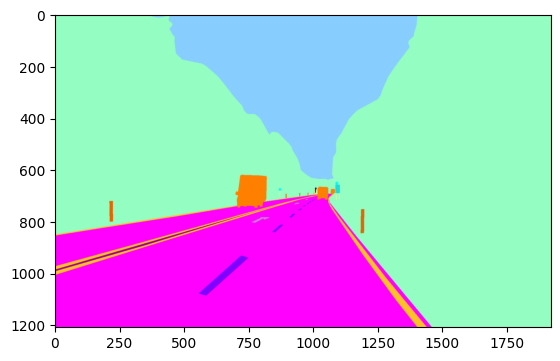

In [17]:

# img_path = '20181008095521_camera_frontcenter_000000595.png'
# img_path = '20181204170238_camera_frontcenter_000000330.png'
img_path = '344951036_830513248597921_5282816303718099792_n.png'
# label_path = '/home/morten/Documents/Data/data_lane_segmentation/val_label/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1061_validation_set_label.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR, img)
# label = cv2.imread(label_path)

img = AudiCam.undistort_image(img, 'front_center', 'cams_lidars.json')

plt.imshow(img)
plt.show()

In [18]:
def ipm_roi(img, camera):
    camera_info = _DictObjHolder({
        "f_x": camera.intrinsic_matrix[0,0],             # focal length x
        "f_y": camera.intrinsic_matrix[1,1],             # focal length y
        "u_x": camera.intrinsic_matrix[0,2],             # optical center x
        "u_y": camera.intrinsic_matrix[1,2],             # optical center y
        "camera_height": camera.estimated_height*1000,   # camera height in `mm`
        "pitch": 90 - camera.estimated_pitch_deg,        # rotation degree around x
        "yaw": camera.estimated_yaw_deg                  # rotation degree around y
    })
    ipm_info = _DictObjHolder({
        "input_width": camera.image_width,
        "input_height": camera.image_height,
        "out_width": camera.image_width,
        "out_height": camera.image_height,
        "left": 200,
        "right": 1750,
        "top": 900,
        "bottom": camera.image_height
    })
    ipm = IPM(camera_info, ipm_info)
    ipm_img = ipm(img)

    left_u = 590
    right_u = 1390

    # limit top and bottom of roi
    top_v = 200
    bottom_v = 1200

    # Create the roi_output
    roi_output = ipm_img[top_v:bottom_v, left_u:right_u]
    # roi_output = ipm_img

    return roi_output

roi = ipm_roi(img, AudiCam)

(1000, 800, 3)


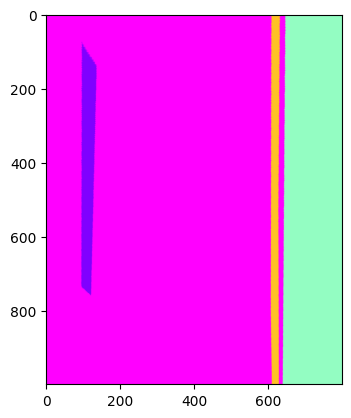

In [19]:
print(roi.shape)
plt.imshow(roi)
plt.show()

In [20]:
roi = cv2.cvtColor(roi, cv2.COLOR_RGB2BGR)
cv2.imwrite('LabelIPM.png', roi)

True

In [19]:

def extract_IPM_save(folder_path, camera):
    i = 0
    childFolder = '/camera/cam_front_center/'
    entirePath = folder_path + childFolder
    newFolder = folder_path + '_IPM' + childFolder
    for filename in tqdm(os.listdir(entirePath)):
        f = filename
        # print(entirePath + f)
        img = cv2.imread(entirePath + f)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR, img)
        img = camera.undistort_image(img, 'front_center', 'cams_lidars.json')
        roi = ipm_roi(img, camera)
        newf = f.split('.')
        newf = newf[0]
        # print(newf)
        newf = newf + '_IPM.png'
        cv2.imwrite(newFolder + newf, roi)
        # if i == 5:
        #     break
        # i = i + 1
    



    

folder = '/home/morten/Audi/20181204_191844'
childFolder = '/camera/cam_front_center/'
os.makedirs(folder + '_IPM' + childFolder)

extract_IPM_save(folder, AudiCam)

 50%|█████     | 942/1878 [1:06:35<1:06:09,  4.24s/it]


KeyboardInterrupt: 